# Forecasting the outflow of customers of a telecom operator

## Purpose

A telecom operator wants to learn how to predict customer churn. If it turns out that the user plans to leave, he will be offered promotional codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.  

**Task**  

It is necessary to predict whether the client will leave the telecom operator in the near future or not. We have been provided with personal data about some customers, historical data on their behavior and termination of contracts with a telecom operator. It is necessary to build a model with an AUC-ROC metric value of at least 0.85.  

**Data description**

The data consists of files obtained from various sources:  

- `contract.csv` - information about the contract;  
- `personal.csv` - personal data of the client;  
- `internet.csv` - information about Internet services;  
- `phone.csv` - information about telephony services.  

In all files, the `customerID` column contains the customer ID.  
Information on contracts is current as of February 1, 2020.  

*Target feature*

- The fact that the client left

## Exploratory data analysis

We import all the necessary libraries for the study.

In [1]:
!pip install phik

In [2]:
RANDOM_STATE = 300123

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

Let's download and examine the data.

**1) Dataframe with information about the contract.**

In [3]:
try:
    df_contract = pd.read_csv('contract.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


This dataframe must contain the target feature - the fact of the client leaving, but it is not in the table. The fact of leaving can be judged by the presence of the end date of the contract.

There are no gaps in the dataframe, but you will need to change the data types of some columns.

In [6]:
df_contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [7]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [8]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In this dataset, it will be necessary to form a target feature and a new feature that reflects how long a person has been a client of the company. For this, the `No` value in the `EndDate` column will need to be replaced with the date 2020-02-01 - the current date of information about contracts.

**2) Dataframe with personal data of clients**

In [9]:
try: 
    df_personal = pd.read_csv('personal.csv')
except: 
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
df_personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [12]:
df_personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [13]:
df_personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

There are no gaps in the dataframe either. You will need to cast the values of the `gender`, `Partner` and `Dependents` columns to a binary form and type *int8*.

**3) Dataframe with information about Internet services**

In [14]:
try: 
    df_internet = pd.read_csv('internet.csv')
except: 
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
df_internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [17]:
df_internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

This dataframe contains 1526 fewer objects than dataframes with information about contracts and personal data. It is possible that clients not included in this dataframe did not use the Internet service. This point must be clarified with the customer.

**4) Dataframe with information about telephony services**

In [18]:
try: 
    df_phone = pd.read_csv('phone.csv')
except: 
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
    
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
df_phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


This dataframe contains 682 fewer objects than dataframes with information about contracts and personal data. It is possible that clients not included in this dataframe did not use Landline Telephony. This point must be clarified with the customer.

## Work plan

This work consists of the following steps:  
1) Data preprocessing in datasets:  
- in the dataframe with information about contracts, change the data type of the `BeginDate` and `EndDate` columns from *object* to *datetime*, and the `TotalCharges` column from *object* type to *float* type, form the target attribute "Exited" and a new attribute - how long in days a person has been a client. Let's remove signs with dates.  


2) Combining dataframes and preprocessing a single dataframe:  
- we will form features that reflect whether the client used Internet and telephony services and remove insignificant features with details of each service;  
- let's bring all binary signs to the numeric type *int*;  
- check and process omissions and anomalies;  
- perform OHE feature coding for the logistic regression model;  
- check the sample for class imbalance and take it into account when training models;  
- explore the multicollinearity of features.

3) Divide the dataframe into training and test samples in the ratio of 75% / 25%, respectively.  

4) Train different models on the data and find the best AUC-ROC metric using cross-validation:  
- LogisticRegression  
- LGBMClassifier  
- Cat Boost Classifier  

4) Model testing:  
- we will conduct final testing of the best model on a test sample;  
- explore the importance of features and the error matrix for the best model.  

5) Summarize the results of the study and write a general conclusion.  

## Data preprocessing

### `Contract` dataframe with information about contracts

Let's form the target feature in the `Exited` column with the following values:  
1 - if the client has left the telecom operator (the `EndDate` column contains the end date of the contract),  
0 - the client has not left the telecom operator (in the `EndDate` column, the value is No)  

In [21]:
df_contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [22]:
df_contract['Exited'] = np.where(df_contract['EndDate'] == 'No', 0, 1)

Let's convert the sign `PaperlessBilling` to a binary format.

In [23]:
df_contract['PaperlessBilling'] = np.where(df_contract['PaperlessBilling'] == 'No', 0, 1)

Fill in all the fields of the `EndDate` column with the value `No` and the value `2020-02-01`, that is, the client did not terminate the contract.

In [24]:
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')

Let's change the data type of the `BeginDate` and `EndDate` columns from object to datetime, and the `TotalCharges` column from type *object* to type *float*.

In [25]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract = df_contract.astype({'PaperlessBilling': 'int8', 'Exited': 'int8'})

In the `Duration` column, we will create a new feature - how long in days a person has been a client. Then we remove the `BeginDate` and `EndDate` columns.

In [26]:
df_contract['Duration'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract['Days'] = df_contract['Duration'].dt.days.astype('int32')
df_contract = df_contract.drop(['EndDate', 'BeginDate', 'Duration'], axis=1)

Let's set the `customerID` column as an index, since it is common to all four dataframes.

In [27]:
df_contract = df_contract.set_index('customerID')
df_contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Days
customerID,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,31
5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,61
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,1,61


In [28]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int8   
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Exited            7043 non-null   int8   
 6   Days              7043 non-null   int32  
dtypes: float64(2), int32(1), int8(2), object(2)
memory usage: 316.4+ KB


### Dataframe `personal` with personal data of clients

Let's convert the values of the `gender`, `Partner` and `Dependents` columns to a binary form.

In [29]:
df_personal['gender'] = np.where(df_personal['gender'] == 'Male', 0, 1).astype('int8')
df_personal['Partner'] = np.where(df_personal['Partner'] == 'No', 0, 1).astype('int8')
df_personal['Dependents'] = np.where(df_personal['Dependents'] == 'No', 0, 1).astype('int8')
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].astype('int8')

Let's set the customerID column as an index.

In [30]:
df_personal = df_personal.set_index('customerID')
df_personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,1,0,1,0
5575-GNVDE,0,0,0,0
3668-QPYBK,0,0,0,0
7795-CFOCW,0,0,0,0
9237-HQITU,1,0,0,0


### `Internet` dataframe with information about Internet services

Let's create a sign of the presence of the Internet service `isInternetService`. We will remove the remaining insignificant signs.

In [31]:
df_internet = df_internet.set_index('customerID')
df_internet['isInternetService'] = 1
df_internet = df_internet['isInternetService']

### Dataframe `phone` with information about telephony services

Let's create a sign of the presence of the telephony service `isPhone`. We will remove the remaining insignificant signs.

In [32]:
df_phone = df_phone.set_index('customerID')
df_phone['isPhone'] = 1
df_phone = df_phone['isPhone']

### Combining dataframes. Preprocessing of the combined dataframe.

Let's merge four dataframes into one.

In [33]:
merged_df = df_contract.join([df_personal, df_internet, df_phone])

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   int8   
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   TotalCharges       7032 non-null   float64
 5   Exited             7043 non-null   int8   
 6   Days               7043 non-null   int32  
 7   gender             7043 non-null   int8   
 8   SeniorCitizen      7043 non-null   int8   
 9   Partner            7043 non-null   int8   
 10  Dependents         7043 non-null   int8   
 11  isInternetService  5517 non-null   float64
 12  isPhone            6361 non-null   float64
dtypes: float64(4), int32(1), int8(6), object(2)
memory usage: 453.9+ KB


Fill in the gaps in the `isInternetService` and `isPhone` columns with zeros, which will indicate the absence of these services from clients.

In [35]:
merged_df[['isInternetService', 'isPhone']] = merged_df[['isInternetService', 'isPhone']].fillna(0)
merged_df = merged_df.astype({'isInternetService': 'int8', 'isPhone': 'int8'})

Let's delete the rows with gaps in the `TotalCharges` column, since we have no way to fill them.

In [36]:
merged_df = merged_df.dropna()
merged_df.isna().sum()

Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Exited               0
Days                 0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
isInternetService    0
isPhone              0
dtype: int64

Check the dataframe for duplicate rows.

In [37]:
print(f'The table has {merged_df.duplicated().sum()} duplicate rows.')

The table has 19 duplicate rows.


Remove duplicate lines.

In [38]:
merged_df = merged_df.drop_duplicates()

By conducting an exploratory analysis of the dataframe data separately, we made sure that there are no implicit duplicates in the columns.

We examine the dataframe for anomalies and outliers.

In [39]:
merged_df.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Days,gender,SeniorCitizen,Partner,Dependents,isInternetService,isPhone
count,7013,7013.000000,7013,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000
unique,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Month-to-month,NaN,Electronic check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3856,NaN,2361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.593041,NaN,64.879524,2289.392243,0.265364,990.130472,0.495651,0.162698,0.483816,0.299301,0.785113,0.903037
std,NaN,0.491302,NaN,30.064371,2266.812153,0.441558,746.501477,0.500017,0.369116,0.499774,0.457985,0.410773,0.295928
min,NaN,0.000000,NaN,18.250000,18.800000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,NaN,35.750000,406.950000,0.000000,276.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,NaN,1.000000,NaN,70.400000,1402.250000,0.000000,883.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,NaN,1.000000,NaN,89.900000,3807.350000,1.000000,1703.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


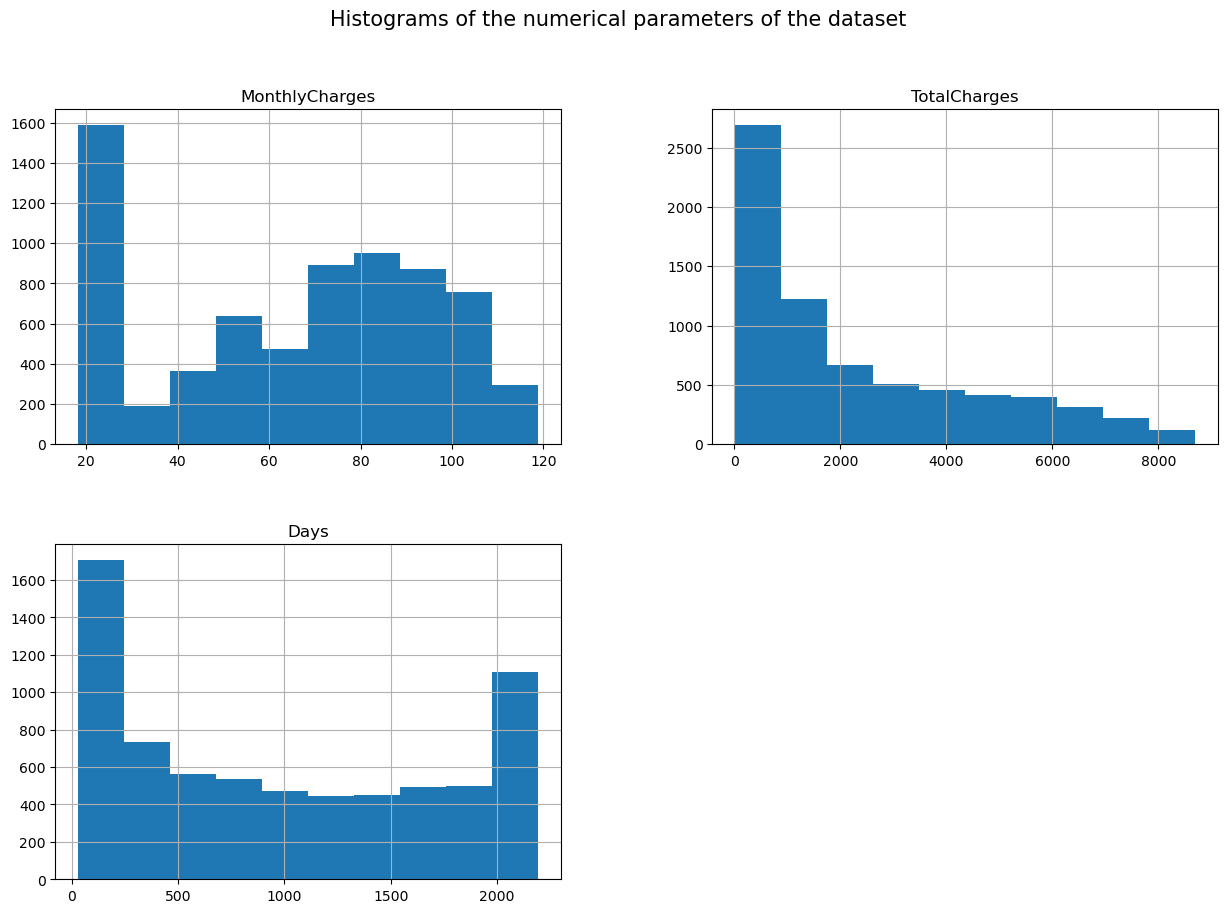

In [40]:
merged_df[['MonthlyCharges', 'TotalCharges', 'Days']].hist(figsize=(15, 10));
plt.suptitle("Histograms of the numerical parameters of the dataset", fontsize=15);

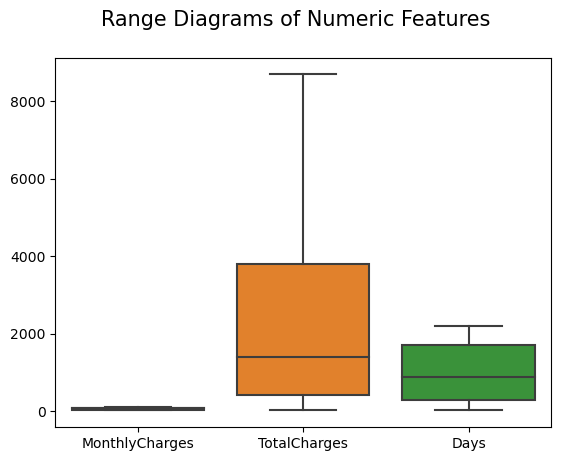

In [41]:
sns.boxplot(data=merged_df[['MonthlyCharges', 'TotalCharges', 'Days']]);
plt.suptitle('Range Diagrams of Numeric Features', fontsize=15);

There are no anomalies and outliers of numerical values that require processing.

Let's look at the class imbalance.

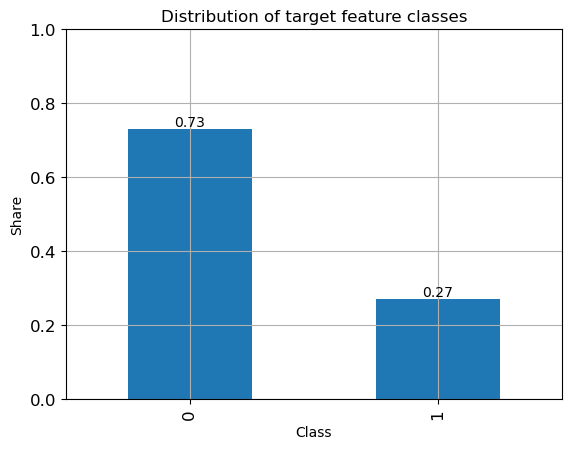

In [42]:
ax = merged_df['Exited'].value_counts(normalize=True).round(2).plot.bar(ylim=(0, 1), 
                                                                        grid=True, 
                                                                        title='Distribution of target feature classes', 
                                                                        xlabel='Class', ylabel='Share', fontsize=12)
ax.bar_label(ax.containers[0], label_type='edge');

There is a class imbalance. We will take this into account when splitting into training and test sets, as well as when training models.

We examine the sample for multicollinearity: we will build a heat map of feature correlations.

CPU times: total: 766 ms
Wall time: 16min 32s


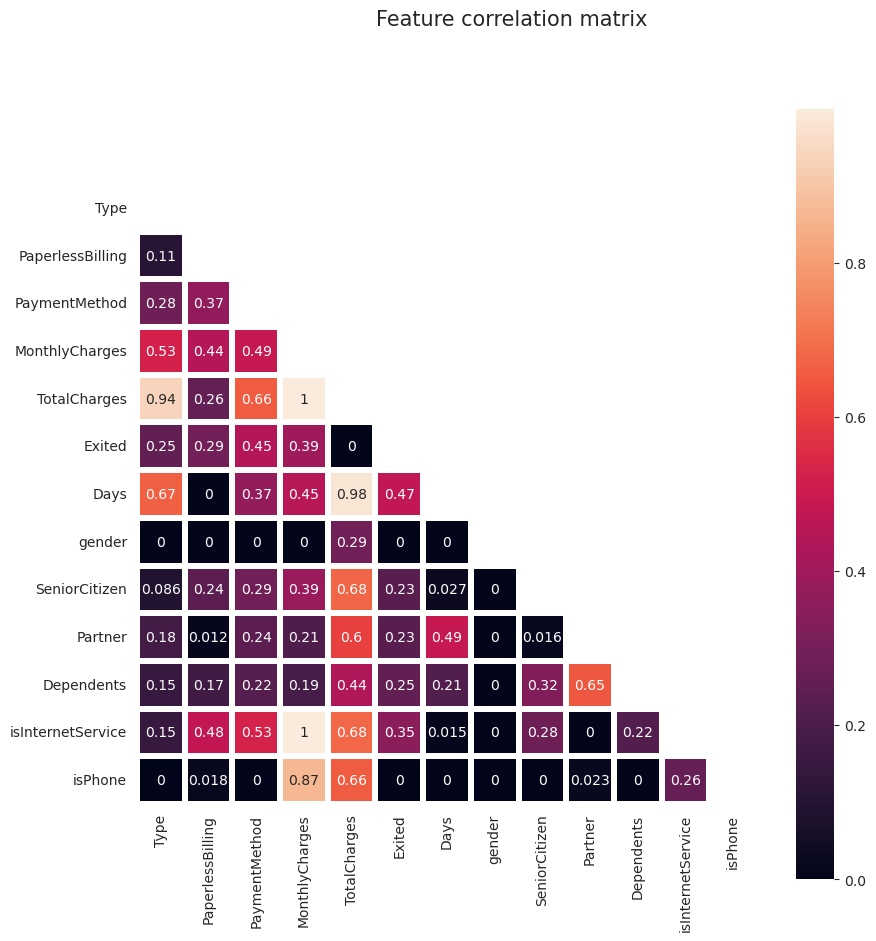

In [43]:
%%time

df_corr = merged_df.phik_matrix(interval_cols=['Days'])
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.suptitle('Feature correlation matrix', fontsize=15);
    ax = sns.heatmap(df_corr, mask=mask, square=True, annot=True, linewidths=3, linecolor='white')

Let's write a function **get_correl** that will display the correlated columns and their coefficient depending on the correlation threshold.
The function takes as input:
- correlation threshold value,
- matrix of correlation coefficients of features

The function returns: pairs of correlated features and their coefficient, if it is above the threshold.

In [44]:
def get_correl(thresh, cor):
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    all_cor = c1[c1.values != 1]
    return all_cor[abs(all_cor) > thresh]

Let's derive pairs of correlated columns for a threshold of 0.80.

In [45]:
get_correl(0.8, df_corr)

MonthlyCharges     TotalCharges      0.999992
isInternetService  MonthlyCharges    0.997731
Days               TotalCharges      0.983366
Type               TotalCharges      0.941354
isPhone            MonthlyCharges    0.866657
dtype: float64

There is a strong correlation between the displayed features. This can negatively affect the quality of the linear logistic regression model. For this model, the attributes `TotalCharges`, `isInternetService`, `isPhone` will need to be removed to get rid of multicollinearity. Tree-based algorithms are immune to multicollinearity.

### Conclusions

As a result of the data preprocessing, the following results were obtained:  
1) formed the target feature based on the values of the `EndDate` column;  
2) formed new features:  
- `Days` - how long in days the person was a client of a telecom operator  
- `isInternetService` - whether the client used Internet services or not  
- `isPhone` - whether the client used telephony services or not  

3) removed insignificant signs: `BeginDate`, `EndDate` and signs with details of each service;  
4) converted all binary features to the numeric type *int8* ;  
5) combined all tables and pre-processed the combined dataframe: processed gaps, checked for anomalies, removed 19 duplicate ;  
6) the sample was checked for class imbalance: the class imbalance of the target trait was 73% to 27%;  
7) investigated the relationship of features and found a close direct relationship between some pairs of features. For the logistic regression model, the features `TotalCharges`, `isInternetService`, `isPhone` must be removed.  

## Features preparation

We divide the sample into features and the target feature.

In [46]:
features = merged_df.drop('Exited', axis=1)
target = merged_df['Exited'] 

Let's divide the sample into training and test in the ratio of 75% and 25%, respectively.

In [47]:
# To make the number of classes in the datasets evenly distributed, specify the stratify=target parameter.
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE, 
                                                                            stratify=target)

Let us encode categorical features for the logistic regression model using the OHE direct coding technique.

In [48]:
# categorical features for OHE
cat_features = features_train.select_dtypes(include='object').columns.to_list()

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

# remove features to get rid of multicollinearity
features_train_ohe = features_train_ohe.drop(['TotalCharges', 'isInternetService', 'isPhone'], axis=1)
features_test_ohe = features_test_ohe.drop(['TotalCharges', 'isInternetService', 'isPhone'], axis=1)

# train the encoder on the given categorical features of the training set
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_features])

# with an encoder that is trained on the training sample, encode the samples
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[cat_features])
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[cat_features])

# remove uncoded categorical features (original columns)
features_train_ohe = features_train_ohe.drop(cat_features, axis=1)
features_test_ohe = features_test_ohe.drop(cat_features, axis=1)

In [49]:
features_train_ohe.head()

,PaperlessBilling,MonthlyCharges,Days,gender,SeniorCitizen,Partner,Dependents,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,
2892-GESUL,0,19.35,549,1,0,1,1,0.0,1.0,0.0,0.0,1.0
2030-BTZRO,1,20.40,184,0,0,1,1,0.0,1.0,1.0,0.0,0.0
3692-JHONH,1,106.50,1584,1,1,1,0,1.0,0.0,0.0,1.0,0.0
6992-TKNYO,0,69.00,1157,0,0,1,0,1.0,0.0,1.0,0.0,0.0
6595-COKXZ,1,44.45,30,1,0,0,0,0.0,0.0,0.0,0.0,1.0


## Models training

Let's write the **get_best_model** function to search for hyperparameters on the GridSearchCV grid for the best model on the AUC-ROC metric.  

The function takes as input:  
- model,  
- hyperparameters for grid search GridSearchCV,  
- features and target feature of the training sample.  

The function returns:  
- AUC-ROC metric of the best model  
- Trained model with the best AUC-ROC metric  

In [50]:
def get_best_model(clf, grid_params, model_name, X_train, y_train):
      
    grid = GridSearchCV(estimator=clf, param_grid=grid_params, scoring='roc_auc', cv=3)
    grid.fit(X_train, y_train)
    
    print(f'{model_name} best model hyperparameters: {grid.best_params_}')
    
    best_roc_auc = grid.best_score_.round(2)
    print(f'{model_name} best AUC-ROC on cv: {best_roc_auc}')
    
    return best_roc_auc, grid.best_estimator_

### LogisticRegression

In the sample for logistic regression, all features are numerical, since OHE coding was applied. We bring all the features to the same scale.

In [51]:
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

Find the best logistic regression model.

In [52]:
%%time

clf = LogisticRegression(random_state=RANDOM_STATE)
grid_params = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
               'max_iter': [100, 200],
               'C': range(1, 10),
               'class_weight': ['balanced', None],
               'penalty': ['l1', 'l2', 'elasticnet', None],
               'tol': [0.0001, 0.001]}

LR_AUC_ROC_cv, LR_best_model = get_best_model(clf, grid_params, 'LogisticRegression', features_train_ohe, target_train)

LogisticRegression best model hyperparameters: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
LogisticRegression best AUC-ROC on cv: 0.83
CPU times: total: 30.1 s
Wall time: 22.4 s


### CatBoostClassifier

Let's find the best CatBoostClassifier model, taking into account the imbalance of classes.

In [53]:
%%time

clf_cb = CatBoostClassifier(eval_metric='AUC', loss_function='Logloss', logging_level='Silent', iterations=500,
                            auto_class_weights='Balanced', random_state=RANDOM_STATE)
pool_train = Pool(features_train, label=target_train, cat_features=cat_features)

grid_params = {'learning_rate': [0.1, 0.3, 0.5],
               'depth': range(2, 10, 2),
               'l2_leaf_reg': range(2, 10, 2)}

catboost_grid = clf_cb.grid_search(grid_params,
                                   X=pool_train,
                                   verbose=False,
                                   plot=False)

print(f"Hyperparameters of the Best CatBoostRegressor Model: {catboost_grid['params']}")
CB_AUC_ROC_cv = np.mean(catboost_grid['cv_results']['test-AUC-mean']).round(2)
print(f'Best AUC-ROC CatBoostRegressor: {CB_AUC_ROC_cv}')

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

Let's measure the training and prediction time of the best model on the training set.

In [54]:
%%time

model = CatBoostClassifier(eval_metric='AUC', 
                           loss_function='Logloss', 
                           logging_level='Silent', 
                           iterations=500,
                           auto_class_weights='Balanced', 
                           depth=2, 
                           l2_leaf_reg=2, 
                           learning_rate=0.5, 
                           random_state=RANDOM_STATE)
model.fit(features_train, target_train, cat_features=cat_features, verbose=False)

CPU times: total: 2.8 s
Wall time: 5.05 s


In [55]:
%%time

print(f'AUC-ROC of the CatBoostClassifier model on the training set: {roc_auc_score(target_train, model.predict_proba(features_train)[:, 1])}')

AUC-ROC of the CatBoostClassifier model on the training set: 0.9745910619224187
CPU times: total: 31.2 ms
Wall time: 11.3 ms


### LGBMClassifier

Let's find the best LGBMClassifier mo

In [56]:
%%time

#объявим категориальные признаки
features_train.loc[:, cat_features] = features_train.loc[:, cat_features].astype('category')

clf = LGBMClassifier(silent=True, random_state=RANDOM_STATE)
grid_params = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'max_depth': range(2, 10, 2),
               'n_estimators': [50, 100, 200, 500, 1000],
               'learning_rate': [0.1, 0.3, 0.5],
               'importance_type': ['split', 'gain']}

LGMB_AUC_ROC_cv, LGMB_best_model = get_best_model(clf, grid_params, 'LGBMClassifier', features_train, target_train)

LGBMClassifier best model hyperparameters: {'boosting_type': 'gbdt', 'importance_type': 'split', 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1000}
LGBMClassifier best AUC-ROC on cv: 0.91
CPU times: total: 36min 1s
Wall time: 5min 24s


Let's measure the training and prediction time of the best model on the training set.

In [57]:
%%time

model = LGBMClassifier(silent=True, 
                       random_state=RANDOM_STATE, 
                       boosting_type='gbdt', 
                       importance_type='split', 
                       learning_rate='0.3',
                       max_depth=2,
                       n_estimators=1000)
model.fit(features_train, target_train)

CPU times: total: 1.31 s
Wall time: 197 ms


LGBMClassifier(learning_rate='0.3', max_depth=2, n_estimators=1000,
               random_state=300123)

In [58]:
%%time

print(f'AUC-ROC of the LGBMClassifier model on the training set: {roc_auc_score(target_train, model.predict_proba(features_train)[:, 1])}')

AUC-ROC of the LGBMClassifier model on the training set: 0.9786859130076168
CPU times: total: 219 ms
Wall time: 49.2 ms


## Models analysis

Let's summarize all the values of model quality metrics in a table.

In [68]:
index = ['LogisitcRegression', 'CatBoostClassifier', 'LGBMClassifier']
data = {'AUC-ROC on the training set':[LR_AUC_ROC_cv,
                                                CB_AUC_ROC_cv,
                                                LGMB_AUC_ROC_cv],
        'Time of prediction(ms)':['-',
                                  11.3,
                                  49.2]
       }

pd.DataFrame(data=data, index=index).sort_values(by='AUC-ROC on the training set', ascending=False)

,AUC-ROC on the training set,Time of prediction(ms)
CatBoostClassifier,0.91,11.3
LGBMClassifier,0.91,49.2
LogisitcRegression,0.83,-


The CatBoostClassifier and LGBMClassifier models showed the same result in the AUC-ROC metric on the training set, but the CatBoostClassifier model outperforms the prediction time by two times. The best model on the training set is CatBoostClassifier.

## Testing

The best cross-validation model was the CatBoostClassifier model with hyperparameters:  
**{loss_function='Logloss', iterations=500, auto_class_weights='Balanced', 'depth': 2, 'l2_leaf_reg': 2, 'learning_rate': 0.5}**  

Let's check the quality of the best model on the test sample, derive the error matrix and examine the importance of the features.

In [69]:
predictions_cb = clf_cb.predict(features_test)
proba_one_cb = clf_cb.predict_proba(features_test)[:, 1]

data = {'CatBoostClassifier': 
              [
                  accuracy_score(target_test, predictions_cb).round(2),
                  recall_score(target_test, predictions_cb).round(2),
                  precision_score(target_test, predictions_cb).round(2),
                  f1_score(target_test, predictions_cb).round(2),
                  roc_auc_score(target_test, proba_one_cb).round(2)
              ]
       }
index=['Accuracy', 'Recall', 'Precision', 'F1', 'ROC-AUC']
pd.DataFrame(data=data, index=index)

,CatBoostClassifier
Accuracy,0.87
Recall,0.79
Precision,0.73
F1,0.76
ROC-AUC,0.93


Error matrix of CatBoostClassifier model on the test set:


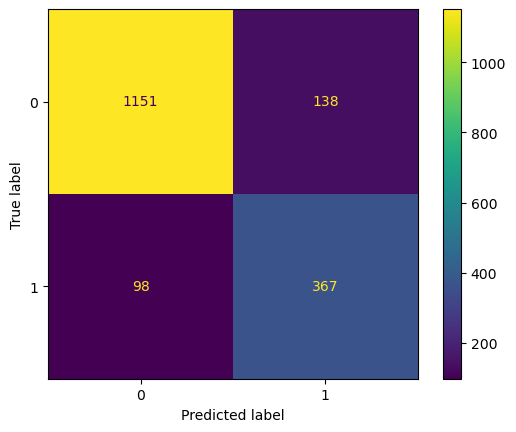

In [70]:
print('Error matrix of CatBoostClassifier model on the test set:')
cm = confusion_matrix(target_test, predictions_cb, labels=clf_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_cb.classes_)
disp.plot();

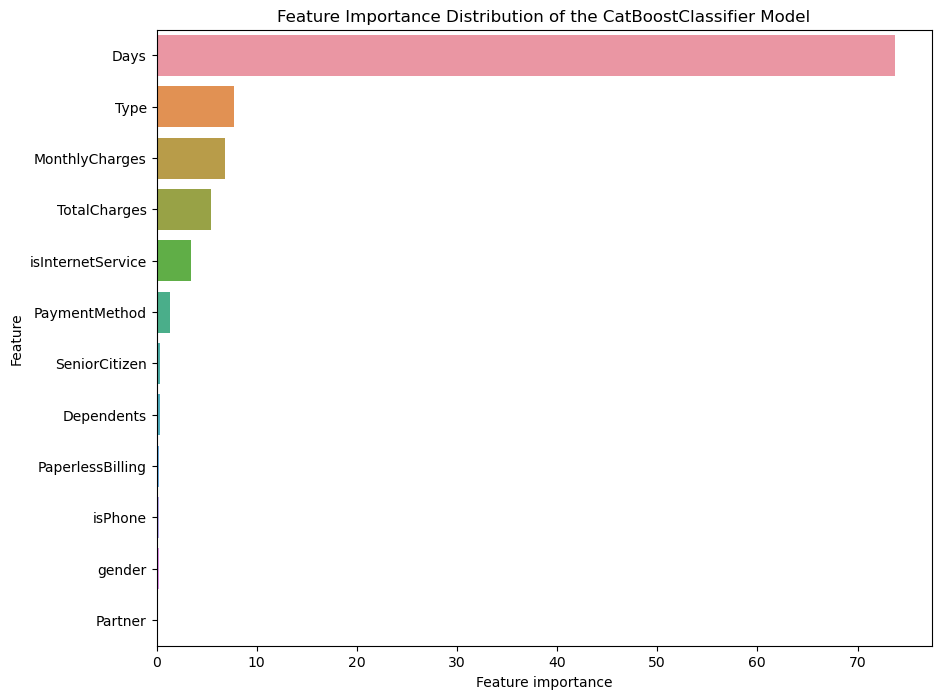

In [71]:
feature_importance = np.array(clf_cb.get_feature_importance())
feature_names = np.array(features_train.columns)
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('Feature Importance Distribution of the CatBoostClassifier Model')
plt.xlabel('Feature importance')
plt.ylabel('Feature');

**Conclusions**
- AUC-ROC on the test sample - 0.93  
- 367 true positives, 98 false negatives (Recall = 0.79) and 138 false positives (Precision = 0.73)  
- 5 most important features for the CatBoostClassifier model:  

1) `Days` - the longer a person is a client of the company, the less likely it is that he will leave  

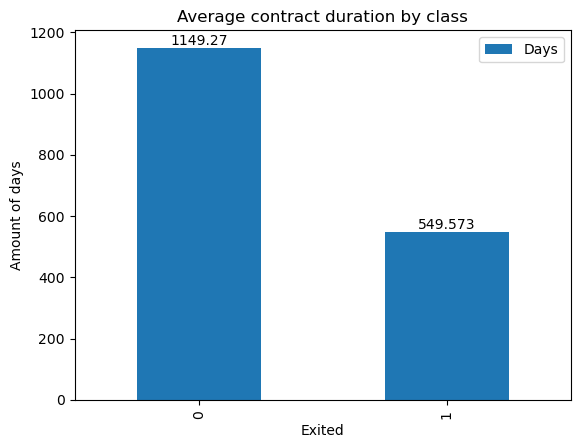

In [72]:
ax = merged_df.pivot_table(index='Exited', values='Days', aggfunc='mean').plot(kind='bar', 
                                                                               title='Average contract duration by class', 
                                                                               ylabel='Amount of days')
ax.bar_label(ax.containers[0], label_type='edge');

2) `Type` - clients who pay for services immediately for a year or two practically do not leave

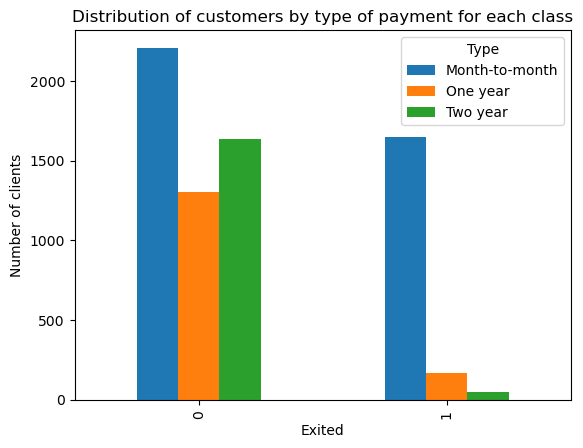

In [73]:
merged_df.pivot_table(index='Exited', columns='Type', values='Days', aggfunc='count').plot(kind='bar', 
                                                                                           title='Distribution of customers by type of payment for each class',
                                                                                           ylabel='Number of clients');

3) `MonthlyCharges` - the average bill for the month of departed customers is higher.

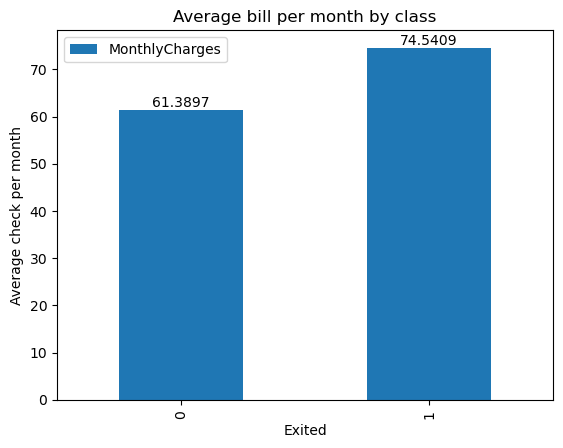

In [74]:
ax = merged_df.pivot_table(index='Exited', values='MonthlyCharges', aggfunc='mean').plot(kind='bar', 
                                                                                         title='Average bill per month by class', 
                                                                                         ylabel='Average check per month')
ax.bar_label(ax.containers[0], label_type='edge');

4) `TotalCharges` - it is also logical here, if a person remains a client, he continues to pay and his total check is greater than that of the departed client.

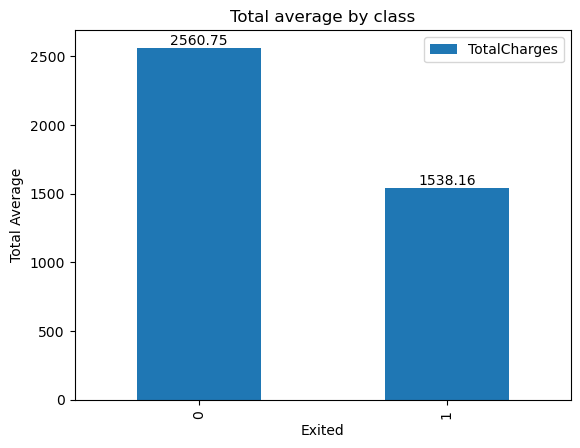

In [75]:
ax = merged_df.pivot_table(index='Exited', values='TotalCharges', aggfunc='mean').plot(kind='bar', 
                                                                                       title='Total average by class', 
                                                                                       ylabel='Total Average')
ax.bar_label(ax.containers[0], label_type='edge');

5) `isInternetService` - mostly clients with connected Internet service leave.

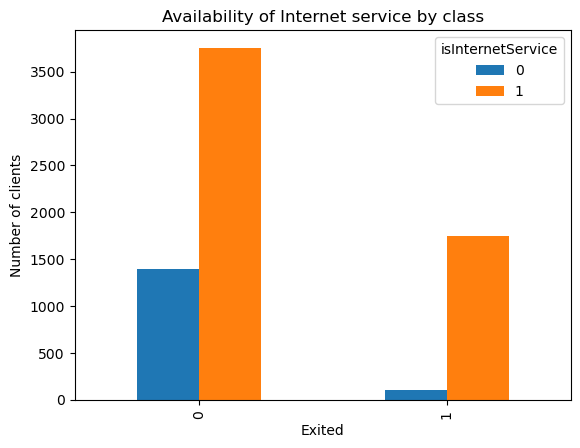

In [76]:
ax = merged_df.pivot_table(index='Exited', columns='isInternetService', values='Days', aggfunc='count').plot(kind='bar', 
                                                                                                             title='Availability of Internet service by class', 
                                                                                                             ylabel='Number of clients')

## General conclusion

In this work, models were investigated that can analyze the behavior of the telecom operator's clients on the available data and predict whether the client will leave the operator or not, that is, solve the classification problem.  

The initial data were provided in four datasets. As a result of the preprocessing, the data were prepared for further training of the models as follows:  

1) formed a target feature based on the values of the EndDate column: the fact that the client left (left - 1, did not leave - 0);  
2) formed new features:  
`Days` - how many days the person has been a client of a telecom operator  
`isInternetService` - whether the client used Internet services or not  
`isPhone` - whether the client used telephony services or not  
3) removed insignificant signs: `BeginDate`, `EndDate` and signs with details of each service;  
4) converted all binary features to the numeric type int8 ;  
5) combined all tables and pre-processed the combined dataframe: processed gaps, checked for anomalies, removed 19 duplicate rows. As a result, we received a dataset consisting of 7013 rows and 13 features (including the target one);  
6) the sample was checked for class imbalance: class imbalance of the target trait 0 - 73%, 1 - 27%;  
7) investigated the relationship of features and found a close direct relationship between some pairs of features. For the logistic regression model, the features `TotalCharges`, `isInternetService`, `isPhone must be removed` have been removed to avoid multicollinearity.  
8) divided the sample into training and test in the ratio of 75% to 25%, respectively;  
9) for the LogisticRegression model, the categorical features `Type` and `PaymentMethod` were converted into numerical ones by the OHE technique, and the features `TotalCharges`, `isInternetService`, `isPhone` were removed due to the close relationship.  

Further, for the LogisticRegression, LGBMClassifier and CatBoostClassifier models, hyperparameters were selected to obtain models with the best AUC-ROC metric on cross-validation. The CatBoostClassifier and LGBMClassifier models showed the same result on the training set, but CatBoostClassifier has a better predictive time.  

As a result, we got the following final model: CatBoostClassifier with hyperparameters  
```
{loss_function='Logloss', iterations=500, 'depth': 2, 'l2_leaf_reg': 2,
'learning_rate': 0.5, auto_class_weights='Balanced', random_state=300123}
```
Quality metrics on the test sample:  
- **ROC-AUC: 0.93**  
- Accuracy: 0.87  
- Recall: 0.79  
- Precision: 0.73  
- F1: 0.76  

The most important features for solving the problem turned out to be:  
- `Days` - how long in days the person was a client of a telecom operator  
- `Type` - how a person pays: monthly, per year or two years  
- `MothlyCharge`, `TotalCharge`, `isInternetService`.  